目的：OCT2Ageモデルを開発し、年齢予測に寄与するグリッドを可視化する

# Libraries

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd; pd.set_option('display.max_columns', None)

import scipy as sp
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()
%precision 3

# utility
import sys
import time
import copy as cp
from tqdm import tqdm
from collections import defaultdict
import pickle
import openpyxl as px
import xlrd
from functools import reduce

# 乱数
rng = np.random.RandomState(1234)
random_state = 42

# ローカルライブラリ
%cd /users/keimy/git/OCT2Age
import src.archetypes as arch

/Users/keimy/git/OCT2Age


# Check Data

In [2]:
from src.preprocess import make_datasets_in_2016

df_cpRNFL, OCT_cpRNFL = make_datasets_in_2016(filenames=["cpRNFL2016.csv"], ROI="cpRNFL")
df_mRNFL, OCT_mRNFL = make_datasets_in_2016(filenames=["mRNFL2016.csv"], ROI="mRNFL")
df_mGCLP, OCT_mGCLP = make_datasets_in_2016(filenames=["mGCLP2016.csv"], ROI="mGCLP")

dfs = [df_cpRNFL, df_mRNFL, df_mGCLP]
df = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs)

dfs_OCT = [OCT_cpRNFL, OCT_mRNFL, OCT_mGCLP]
df_OCT = reduce(lambda left, right: pd.merge(left, right, on=["ID", "topID", "eye"]), dfs_OCT)

df.shape, df_OCT.shape


((7666, 430), (7666, 215))

In [3]:
# df_kenshin = pd.read_csv("../data_kenshin/h2016.csv")
df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)
df_kenshin = df_kenshin.rename(columns={"kenshinID": "ID" })
df_kenshin = df_kenshin.reset_index(drop=True)

# 日付型のdate変数を作成
df_OCT['date'] = pd.to_datetime(df_OCT['topID'].astype(str).str[-8:])
df_kenshin['date'] = pd.to_datetime(df_kenshin['kenshindate'].astype(str))

# IDを文字列型に変換
df_OCT['ID'] = df_OCT['ID'].astype(str)
df_kenshin['ID'] = df_kenshin['ID'].astype(str)

# IDとdateを使ってOCTとkenshinをマージ
df_merged = pd.merge(df_OCT, df_kenshin, on=['ID', 'date'], how='left')

# df_mergedの前処理
# 年齢の欠損を除外
df_merged = df_merged[df_merged['age'].notnull()]

# 問診項目の変数処理
def conversion_to_int(df, filling):
    df2 = pd.to_numeric(df, errors='coerce')
    df2.fillna(1, inplace=True)  # 例: 0で置換
    df2 = df2.astype(np.int64)
    return df2

df_merged["smoking"] = (conversion_to_int(df_merged["mon3x1x1"], 1) != 1).astype(int)
df_merged["drinking"] = (conversion_to_int(df_merged["mon3x2x1"], 0) != 0).astype(int)
df_merged["exercise"] = (conversion_to_int(df_merged["mon5x4x1"], 1) != 1).astype(int)

df_merged["sleep"] = conversion_to_int(df_merged["mon2x2"], 9)
df_merged["short_sleep_6"] = ((df_merged.sleep == 1) | (df_merged.sleep == 2)).astype(int)
df_merged["short_sleep_5"] = (df_merged.sleep == 1).astype(int)


len(df_merged)

/var/folders/2q/37wkg3rj6hb2r8hl9r779vgw0000gn/T/ipykernel_94522/2409096987.py:2: DtypeWarning: Columns (86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,106,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,130,133,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,187,188,189,190,191,192,193,194,199,200) have mixed types. Specify dtype option on import or set low_memory=False.
  df_kenshin = pd.read_csv("./data_kenshin/2016R2.csv"); df_kenshin.drop(index=0, inplace=True)


7662

# OCT2Ageモデル

In [ ]:
import importlib
import src.model.OCT2Age

# モジュールの再読み込み
importlib.reload(src.model.OCT2Age)

# モジュールから必要なクラスや関数をインポート
from src.model.OCT2Age import NN_OCT2Age, train, valid

In [26]:
from src.preprocess import create_scaled_dataloader_per_CV, dataframe_to_tensor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer


def split_dataframe(df):
    # X_df は 'ID', 'topID', 'eye', 'date', 'age' を除くすべての列を含む
    X_df = df.drop(['ID', 'topID', 'eye', 'date', 'age'], axis=1)

    # Y_df は 'age' 列のみを含む
    Y_df = df[['age']]

    return X_df, Y_df

# OCT情報とageだけを残す
col_names = df_OCT.columns.tolist() + ["age"]
XY_df = df_merged[col_names]

# X,Yにスプリット
X_df, Y_df = split_dataframe(XY_df)

# データローダーの作成
n_splits = 3
batch_size = 128

# scaler = StandardScaler()
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = FunctionTransformer()

_, X_test_CV, X_scaler_CV, _, y_test_CV, y_scaler_CV, train_loader_CV, test_loader_CV = create_scaled_dataloader_per_CV(X_df, Y_df, scaler=scaler, n_splits=n_splits, batch_size=batch_size)

Epoch 1/10, Train Loss: 0.05087286573834717, Validation Loss: 0.033258541394025086
Epoch 2/10, Train Loss: 0.031197857204824687, Validation Loss: 0.03144088676199317
Epoch 3/10, Train Loss: 0.030421059997752308, Validation Loss: 0.02962566716596484
Epoch 4/10, Train Loss: 0.030823660222813486, Validation Loss: 0.02925873305648565
Epoch 5/10, Train Loss: 0.029586150776594877, Validation Loss: 0.030956464260816573
Epoch 6/10, Train Loss: 0.029427603492513298, Validation Loss: 0.02989659858867526
Epoch 7/10, Train Loss: 0.029393148655071855, Validation Loss: 0.028678934276103973
Epoch 8/10, Train Loss: 0.02882627905346453, Validation Loss: 0.02947003860026598
Epoch 9/10, Train Loss: 0.028953388705849646, Validation Loss: 0.02863388303667307
Epoch 10/10, Train Loss: 0.028762152325361966, Validation Loss: 0.030354340095072985


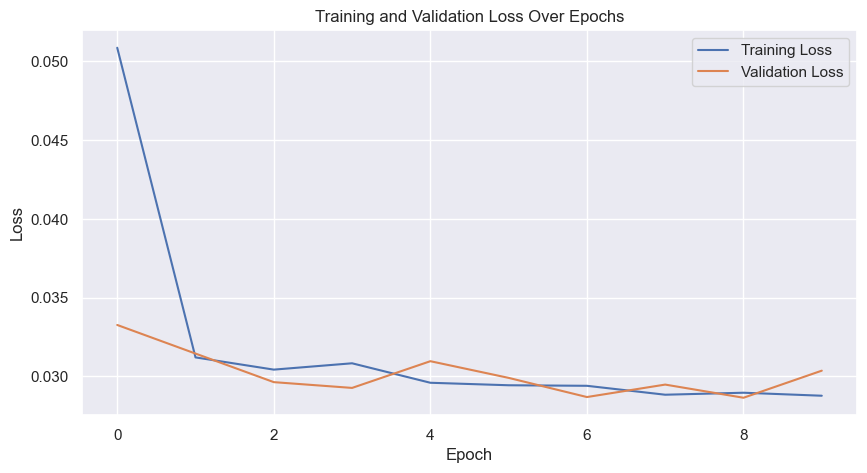

Epoch 1/10, Train Loss: 0.05288552991114557, Validation Loss: 0.03971852250397205
Epoch 2/10, Train Loss: 0.03570622755214572, Validation Loss: 0.038087638281285766
Epoch 3/10, Train Loss: 0.03491146238520741, Validation Loss: 0.03440832309424877
Epoch 4/10, Train Loss: 0.034636385692283514, Validation Loss: 0.0344264724291861
Epoch 5/10, Train Loss: 0.034169535897672174, Validation Loss: 0.033973838295787574
Epoch 6/10, Train Loss: 0.03460245621390641, Validation Loss: 0.033770713675767186
Epoch 7/10, Train Loss: 0.034026520885527135, Validation Loss: 0.03363941144198179
Epoch 8/10, Train Loss: 0.03362968829460442, Validation Loss: 0.03354488974437118
Epoch 9/10, Train Loss: 0.033498636726289985, Validation Loss: 0.03352999743074179
Epoch 10/10, Train Loss: 0.033618797361850736, Validation Loss: 0.037106903642416


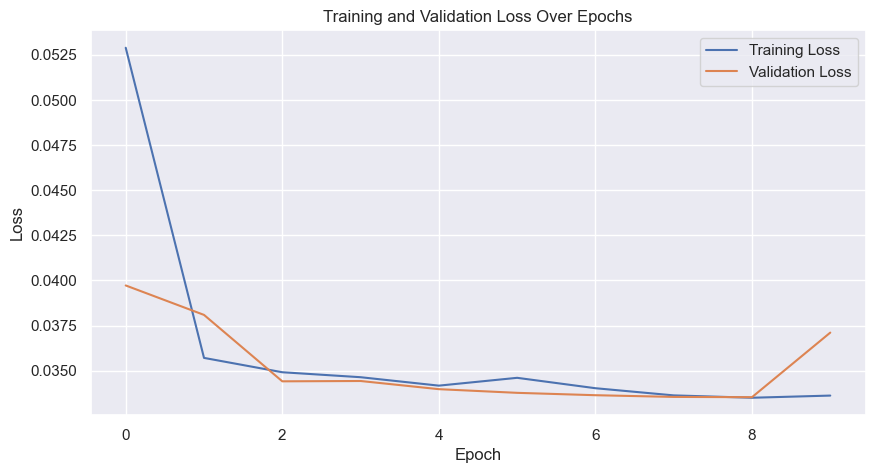

Epoch 1/10, Train Loss: 0.12621219544671475, Validation Loss: 0.031141756847500802
Epoch 2/10, Train Loss: 0.030186590738594532, Validation Loss: 0.029628828447312117
Epoch 3/10, Train Loss: 0.02931094137020409, Validation Loss: 0.03003111304715276
Epoch 4/10, Train Loss: 0.029351406265050173, Validation Loss: 0.030112472642213107
Epoch 5/10, Train Loss: 0.02912206882610917, Validation Loss: 0.02928837426006794
Epoch 6/10, Train Loss: 0.028625057358294726, Validation Loss: 0.028785018343478443
Epoch 7/10, Train Loss: 0.028859414532780646, Validation Loss: 0.028788469079881907
Epoch 8/10, Train Loss: 0.030325749376788735, Validation Loss: 0.029415187425911427
Epoch 9/10, Train Loss: 0.028634519968181848, Validation Loss: 0.028231458645313977
Epoch 10/10, Train Loss: 0.02853536307811737, Validation Loss: 0.028187010996043683


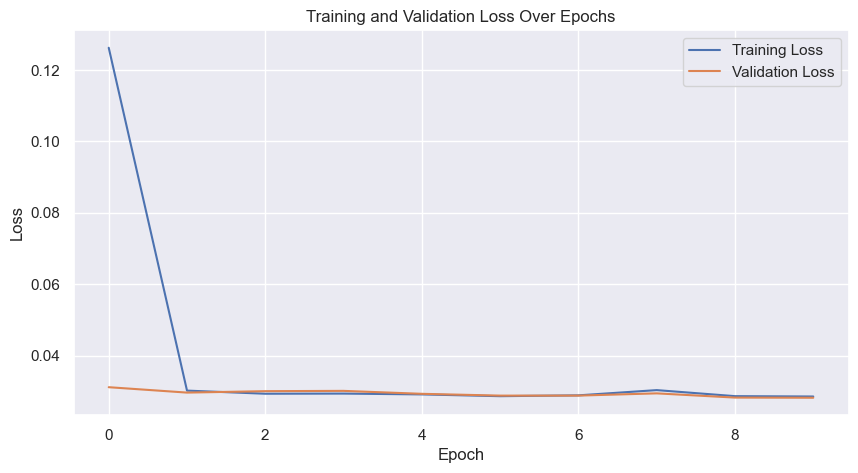

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.model.OCT2Age import NN_OCT2Age, train, valid


# ハイパラ
epochs = 10
dropout_rate = 0
lr = 0.001

# モデルの設定
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"


model_CV = []
for k in range(n_splits):
    model = NN_OCT2Age(input_dim=212, hidden_dims=[64,32], output_dim=1, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    # train and valid per epoch
    for epoch in range(epochs):
        # トレーニング
        train_loss = train(model, train_loader_CV[k], optimizer=optimizer, device=device)
        train_losses.append(train_loss)

        # 検証
        val_loss = valid(model, test_loader_CV[k],device=device)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

    # save model per CV
    model_CV.append(model)

    # 損失のプロット
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [31]:

y_pred_scaled_CV = []
y_pred_CV = []

for k in range(n_splits):
    X_test = X_test_CV[k].to_numpy()

    # X_testにスケーラーを適用
    X_scaler = X_scaler_CV[k]
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)

    # テストデータの予測
    model = model_CV[k]
    model.eval()

    y_pred_scaled = model(X_test_scaled)
    y_pred_scaled_CV.append(y_pred_scaled)

    # 予測結果を元に戻す
    y_scaler = y_scaler_CV[k]
    y_pred = y_scaler.inverse_transform(y_pred_scaled.detach().numpy())
    y_pred_CV.append(y_pred)


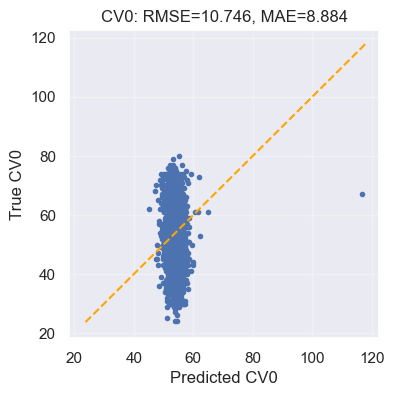

In [32]:
from src.eval_plot import calc_reg_metrics, plot_reg_metrics


k = 0

y_test = y_test_CV[k].to_numpy()
y_scaler = y_scaler_CV[k]
y_test_scaled = y_scaler.transform(y_test)

y_pred_scaled = y_pred_scaled_CV[k].detach().numpy()

calc_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[0])

plot_reg_metrics(y_test_scaled, y_pred_scaled, y_scaler_CV[0], target_name=f"CV{k}")

In [ ]:
from sklearn.metrics import mean_absolute_error

Y_trues = np.array(Y_trues)
Y_preds = np.array(Y_preds)

mae = mean_absolute_error(Y_trues, Y_preds)
mse = np.mean((Y_trues - Y_preds) ** 2)
mae, mse, Y_trues.shape, Y_preds.shape

In [ ]:
df = pd.DataFrame({
    'Y_true': Y_trues,
    'Y_pred': Y_preds
})

# CSVファイルの保存パスを指定
csv_file_path = '../outputs/predictions.csv'

# DataFrameをCSVファイルに保存
df.to_csv(csv_file_path, index=False)

# 保存したCSVファイルのパスを出力
csv_file_path
